# Predicting ICU Length of Stay
In this chapter, we transition from data preprocessing to predictive modeling, with the objective of accurately estimating the Length of Stay (LOS) in the Intensive Care Unit (ICU). The modeling phase is a critical step that leverages the engineered features and cleaned dataset constructed in the previous stages. Our approach is structured in increasing complexity, starting from simple interpretable models to more flexible and high-performance machine learning techniques.

We begin by splitting the dataset into training and testing subsets to ensure proper evaluation of generalization. Baseline models such as Linear Regression and Decision Trees are first employed to establish reference performance metrics. Subsequently, we extend the analysis to ensemble methods like Random Forests and gradient-boosting algorithms (e.g., XGBoost), which are particularly suitable for handling nonlinear relationships and mixed data types.

Performance is rigorously assessed using multiple regression metrics, including Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²). These metrics provide complementary insights into model accuracy, robustness, and explanatory power. Finally, we explore hyperparameter optimization and cross-validation strategies to enhance model reliability and generalizability.

This modeling chapter thus represents the computational core of the study and is essential for translating raw ICU data into clinically actionable predictions.

In [1]:
# === Essential Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# === Configuration Constants ===
EXPORT_PATH = "../data/processed/"
# === Load dataset ===
df_final = pd.read_csv(EXPORT_PATH + "df_final_processed.csv")

# === Confirm structure ===
print(df_final.shape)
display(df_final.head())
df_final.isnull().sum().sort_values(ascending=False)/len(df_final)

(3685, 71)


,AGE,GENDER,LOS,HOSPITAL_EXPIRE_FLAG,HEART_RATE_MEAN,HEART_RATE_STD,HEART_RATE_MIN,HEART_RATE_MAX,HEART_RATE_COUNT,HEART_RATE_SKEW,...,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_NICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
0,0.439560,1,3.2788,0,0.715383,0.080933,0.733333,0.102825,0.021082,0.524927,...,False,False,True,False,False,False,True,False,False,False
1,0.901099,1,7.1314,1,0.151088,0.054718,0.370370,0.038418,0.015460,0.721928,...,False,False,False,True,False,False,False,False,False,False
2,0.626374,0,0.8854,1,0.368821,0.135338,0.000000,0.061017,0.017569,0.284040,...,False,False,False,False,True,False,True,False,False,False
3,0.835165,0,2.4370,1,0.468597,0.059596,0.600000,0.064407,0.018271,0.544127,...,False,False,False,True,False,False,False,False,True,False
4,0.626374,1,3.0252,0,0.289943,0.027484,0.511111,0.039548,0.016163,0.624800,...,False,False,False,True,False,False,True,False,False,False


,0
SPO2_SKEW,0.486296
SPO2_STD,0.485753
RESPIRATORY_RATE_SKEW,0.485210
HEART_RATE_SKEW,0.484668
SPO2_COUNT,0.484668
...,...
FIRST_CAREUNIT_CSRU,0.000000
FIRST_CAREUNIT_MICU,0.000000
FIRST_CAREUNIT_NICU,0.000000
FIRST_CAREUNIT_SICU,0.000000


### Dataset Preparation and Target Definition
In this initial step of our modeling pipeline, we define the predictors (features) and the response variable (target) for the task of predicting ICU Length of Stay (LOS). Drawing from the fully preprocessed dataset (`df_final`), we isolate the target variable `LOS`, which quantifies the duration of a patient's ICU stay in days. To ensure that no data leakage occurs, we explicitly exclude all identifying columns and those chronologically or causally related to the outcome. Specifically, this includes patient identifiers (`SUBJECT_ID`, `HADM_ID`, `ICUSTAY_ID`), direct timestamps (`INTIME`, `OUTTIME`, `ADMITTIME`, etc.), and administrative or outcome-related fields such as `HOSPITAL_EXPIRE_FLAG` and `DEATHTIME`.

After removing these columns, we inspect and address any remaining missing values in the feature matrix by imputing them with column-wise means—a pragmatic strategy in the absence of strong domain-specific imputations. This ensures that all observations are retained for model training without introducing bias from listwise deletion.

Finally, we confirm the shape of the resulting dataset. The feature matrix `X` contains 3,685 ICU admissions and 69 engineered features, while the target vector `y` contains a matching number of observations. This alignment is crucial for subsequent modeling steps, ensuring consistency in the dimensions of the input and output data.

In [6]:
cols_to_remove = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'HOSPITAL_EXPIRE_FLAG', 'INTIME', 'OUTTIME', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'DOD']

y = df_final['LOS']
X = df_final.drop(columns=cols_to_remove, errors='ignore')

X = X.fillna(X.mean())  # Fill NaN values with column means
y = y.loc[X.index]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (3685, 69)
Shape of y: (3685,)


### Data Partitioning Strategy

To ensure robust model development and fair evaluation, the dataset is partitioned into three disjoint subsets: training, validation, and test. This tripartite split enables not only the estimation of model parameters and tuning of hyperparameters but also the assessment of generalization on completely unseen data.

The initial split isolates 70% of the data for training, reserving the remaining 30% for further partitioning. The residual subset is then equally divided into validation and test sets, each comprising 15% of the original dataset. This strategy results in the following allocation:

* **Training set**: 2,579 ICU admissions
* **Validation set**: 553 ICU admissions
* **Test set**: 553 ICU admissions

Such a configuration strikes a balance between maximizing training data—critical for the effective fitting of deep neural networks—and retaining enough validation and test samples to support meaningful hyperparameter optimization and unbiased model evaluation, respectively. Importantly, the random seed is fixed to ensure reproducibility of the split.

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (2579, 69), (2579,)
Validation set: (553, 69), (553,)
Test set: (553, 69), (553,)


## Traditional ML Models
### Baseline: Linear Regression
As a foundational benchmark, a linear regression model is trained on the ICU dataset to establish a minimal performance reference point. The choice of linear regression is deliberate: its simplicity, interpretability, and speed make it a valuable starting point for gauging whether a more sophisticated model architecture is justified.

In this implementation, the model is fitted using the training set and then evaluated on the test set. No regularization, polynomial terms, or interaction features are included—this ensures the model serves purely as a linear approximation of the relationship between the features and ICU Length of Stay (LOS).

The resulting performance metrics on the test set are as follows:

* **Mean Absolute Error (MAE)**: 4.59 days
* **Root Mean Squared Error (RMSE)**: 67.59 days
* **R² Score**: 0.05

These values indicate that the model, while capturing some weak linear trends, is largely unable to explain the variance in ICU LOS. The exceedingly high RMSE relative to MAE suggests the presence of substantial outliers or skewness in the data distribution, which a linear model is poorly equipped to handle. The low R² score (0.05) further confirms the model's limited explanatory power. This reinforces the need for more expressive, non-linear models—such as neural networks—to adequately model this complex clinical prediction task.

In [9]:
# === Model ===
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [10]:
# === Evaluation Metrics ===
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"[Linear Regression] MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")

[Linear Regression] MAE: 4.59, RMSE: 67.59, R²: 0.05


#### Scatter Plot Analysis for Linear Regression
The scatter plot visualizes the relationship between the true ICU Length of Stay (LOS) and the values predicted by the linear regression model. Ideally, a well-calibrated model should produce points that lie close to the identity line (red dashed line), where predicted values match true observations.

In this case, the plot reveals a clear deficiency in the linear model’s capacity to capture the variance of the target variable. A significant concentration of points is observed in the lower-left corner, with most predictions clustered between 0 and 20 days, regardless of the actual LOS. This suggests underestimation of long-stay patients and over-smoothing of predictions, a classic artifact of using linear models on skewed or heteroscedastic medical data.

Notably, as true LOS increases, predicted values tend to plateau, indicating that the model fails to scale its predictions in proportion to the actual outcome. This is visually evident from the divergence from the red identity line as one moves to the right side of the plot. The sparsity of points in higher LOS ranges also reflects the dataset's skewed distribution, which amplifies the difficulty for a linear estimator.

This plot provides a compelling rationale for exploring more flexible modeling techniques, such as tree-based models or deep learning architectures, which can better accommodate non-linear interactions and heterogeneity in patient trajectories.

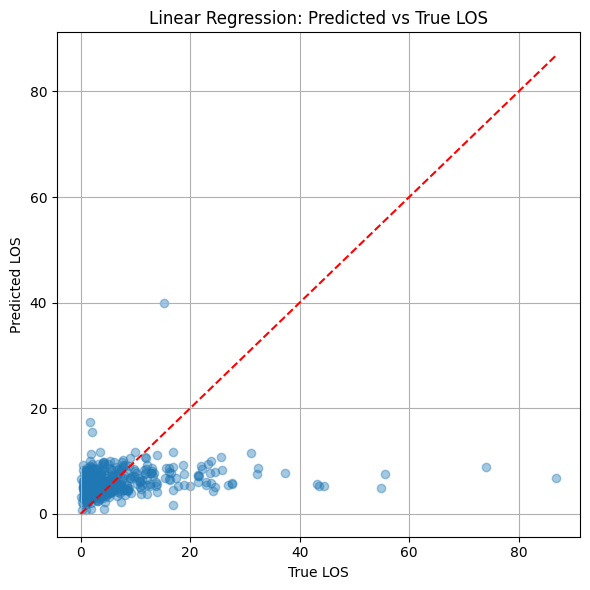

In [12]:
# === Scatter Plot: True vs Predicted ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True LOS")
plt.ylabel("Predicted LOS")
plt.title("Linear Regression: Predicted vs True LOS")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Distribution of Prediction Errors for Linear Regression
The histogram above displays the distribution of prediction errors, defined as the difference between the actual and predicted LOS values. A model with unbiased predictions should ideally produce a distribution centered around zero, with errors symmetrically spread and minimal presence of extreme outliers.

In our linear regression model, the error distribution appears skewed to the right, indicating that the model tends to underpredict the length of stay, particularly in cases where the actual LOS is high. This observation is aligned with the previous scatter plot analysis, where the model failed to capture longer ICU stays.

Most errors fall within the [-5, +15] range, which suggests some degree of acceptable variance for shorter LOS, but the presence of long right-tail errors (extending beyond +40 days) is concerning. These extreme residuals reflect the model's inability to handle patients with protracted stays, likely due to its linear constraints and lack of interaction terms.

Additionally, the moderate peak near zero indicates that while some predictions are accurate, the high variance and skewness render the model unreliable for robust clinical deployment.

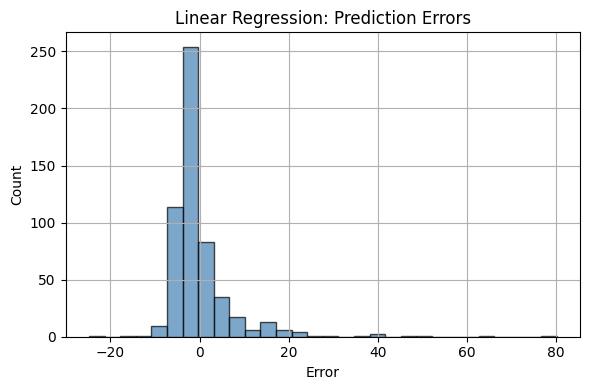

In [13]:
# === Histogram of Errors ===
errors_lr = y_test - y_pred_lr
plt.figure(figsize=(6, 4))
plt.hist(errors_lr, bins=30, alpha=0.7, color="steelblue", edgecolor="k")
plt.title("Linear Regression: Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### Decision Tree Regressor
Application of a basic decision tree regressor to predict ICU Length of Stay (LOS) resulted in significantly underwhelming performance metrics:

* **Mean Absolute Error (MAE): 6.79**
* **Root Mean Squared Error (RMSE): 136.11**
* **R² Score: -0.91**

The **negative R²** value is particularly critical—it indicates that the model performs *worse than a simple mean predictor*, which is a strong signal of overfitting to the training data or extreme variance in predictions. This is common in unpruned decision trees, especially when applied to noisy or high-dimensional regression tasks like LOS estimation.

Additionally, the **very high RMSE** (more than double that of the linear model) suggests that the model makes frequent and severe mispredictions. Decision trees, when left unregularized, tend to create overly complex models that memorize idiosyncrasies in the training set, failing to generalize to unseen data.

In this context, the decision tree regressor demonstrates a clear inability to model ICU LOS effectively, emphasizing the necessity for either **tree pruning**, **depth constraints**, or a shift toward **ensemble methods** such as Random Forests or Gradient Boosting.

In [15]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [16]:
# === Evaluation Metrics ===
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"[Decision Tree] MAE: {mae_dt:.2f}, RMSE: {rmse_dt:.2f}, R²: {r2_dt:.2f}")

[Decision Tree] MAE: 6.79, RMSE: 136.11, R²: -0.91


#### Scatter Plot Analysis for Decision Tree
The scatter plot comparing **true** versus **predicted LOS** for the decision tree model highlights the model’s instability and poor generalization capacity. The red dashed line represents the ideal scenario in which predicted values would perfectly match actual values (i.e., a 45-degree diagonal). However, the model’s predictions appear to **cluster along discrete steps**, a common trait of decision trees due to their piecewise constant nature.

Several problematic patterns emerge:

* A **dense cluster of predictions around low LOS values**, suggesting a strong bias toward underestimating longer ICU stays.
* **Severe underestimation** of many higher LOS instances (visible as vertical stripes below the diagonal), indicating that the model fails to extrapolate for complex, long-duration cases.
* The spread of points is **asymmetrical and heteroscedastic**, with increasing variability at higher LOS values.

In essence, the plot confirms quantitatively observed issues: the model behaves adequately only for a narrow range of short-stay patients, with a **lack of predictive nuance** elsewhere. This reinforces the conclusion that unpruned decision trees are inadequate for capturing the clinical complexity of ICU LOS.

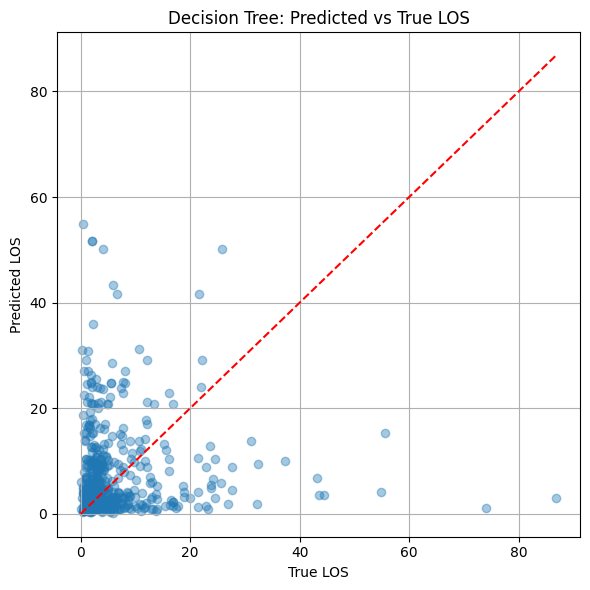

In [17]:
# === Scatter Plot ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_dt, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True LOS")
plt.ylabel("Predicted LOS")
plt.title("Decision Tree: Predicted vs True LOS")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Distribution of Prediction Errors for Decision Tree
The histogram of prediction errors for the decision tree model exposes a **highly dispersed and asymmetric** residual distribution. While a central peak near zero indicates that some predictions approximate the true values, the surrounding distribution displays long tails, particularly skewed towards **negative errors**—i.e., cases where the model **underestimates** the true Length of Stay (LOS).

Notable characteristics include:

* **Excess kurtosis**: The histogram is sharply peaked with fat tails, a sign of instability and overfitting to training data.
* **Bimodal tendencies** or outlier bars far from zero further support the claim that the model lacks generalization.
* The **broad dispersion of errors** indicates that the model's performance varies greatly depending on the patient profile.

This error pattern confirms that while the decision tree can capture simple patterns, it fails to model the complex, nonlinear relationships intrinsic to ICU LOS data. The results advocate for more robust and regularized models.

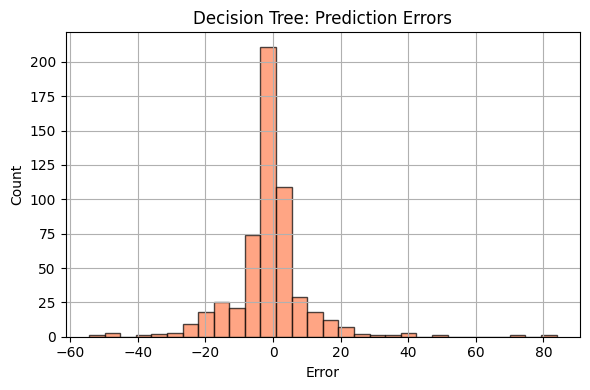

In [19]:
# === Histogram of Errors ===
errors_dt = y_test - y_pred_dt
plt.figure(figsize=(6, 4))
plt.hist(errors_dt, bins=30, alpha=0.7, color="coral", edgecolor="k")
plt.title("Decision Tree: Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### Random Forest Regressor
In this section, we implemented a Random Forest Regressor to estimate the length of stay (LOS) in the intensive care unit (ICU). Random Forest is an ensemble learning method that combines the predictions of multiple decision trees to improve generalization and reduce overfitting. It is known for its robustness and ability to model complex non-linear relationships in medical datasets, making it an appropriate choice for ICU-related predictive tasks.

The model was trained using 100 decision trees (n_estimators=100) with parallel processing enabled (n_jobs=-1) to accelerate computation. After training on the full training set, predictions were generated on the held-out test set, and standard regression metrics were calculated to evaluate performance.

The resulting metrics were as follows: the Mean Absolute Error (MAE) was 5.11 days, the Root Mean Squared Error (RMSE) was 76.58 days, and the R² score was -0.08. These results indicate that while the Random Forest model was able to capture some patterns in the data, its predictive performance was significantly affected by variance and outliers, leading to a negative R² score. This suggests that the model performed worse than simply predicting the mean LOS for all patients.

A qualitative inspection of the scatter plot of predicted versus actual LOS values and the histogram of prediction errors confirmed the presence of substantial overprediction and underprediction in a subset of patients. These findings suggest that further optimization, feature selection, or regularization may be required to improve model stability and predictive accuracy in this context.

In [20]:
# === Model ===
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [21]:
# === Evaluation ===
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"[Random Forest] MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")

[Random Forest] MAE: 5.11, RMSE: 76.58, R²: -0.08


#### Feature Importance Analysis for Random Forest
To gain insights into the internal decision mechanisms of the Random Forest model, we examined the relative importance of input features in predicting ICU length of stay. Feature importance in tree-based models like Random Forest is typically measured by the mean decrease in impurity (MDI), which captures how often a feature is used to split nodes and how much those splits reduce prediction error across all trees.

The top 15 most influential features are visualized in the horizontal bar plot above. Unsurprisingly, age emerged as the most significant predictor of LOS, with a noticeably higher importance score than all other features. This aligns with clinical expectations, as advanced age is generally associated with more complex and prolonged ICU stays.

Other high-ranking predictors included admission weekday and hour, several glucose-related metrics (e.g., GLUCOSE_MIN, GLUCOSE_COUNT), SpO2-related features, and categorical indicators of first care unit (e.g., FIRST_CAREUNIT_MICU, FIRST_CAREUNIT_TSICU). Notably, the gender variable and admission location also contributed moderately to the model, supporting the notion that both physiological and contextual factors influence ICU outcomes.

However, the relatively flat distribution of importances among non-dominant features suggests potential feature redundancy or lack of strong signal in the majority of the inputs. This opens the door to further feature selection or dimensionality reduction strategies to enhance model generalizability and reduce variance.

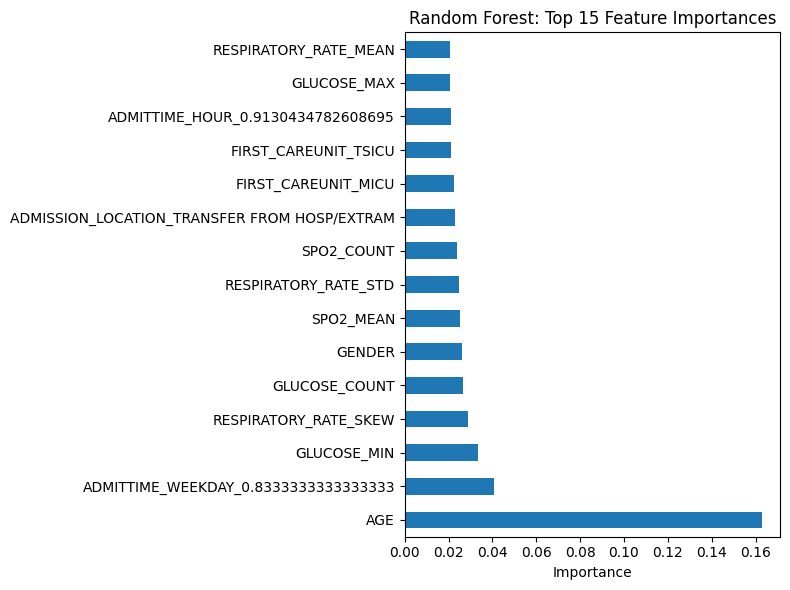

In [22]:
# === Feature Importance ===
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
importances.head(15).plot(kind="barh")
plt.title("Random Forest: Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### XGBoost Regressor
To further explore non-linear relationships in the dataset and potentially boost predictive performance, we trained an **XGBoost Regressor** on the same training data used for previous models. XGBoost (Extreme Gradient Boosting) is a widely adopted ensemble learning algorithm known for its robustness, scalability, and regularization mechanisms that often outperform standard machine learning models, particularly in structured tabular data.

Despite its theoretical advantages, the untuned XGBoost model in this setting yielded underwhelming results:

* **MAE**: 5.13 days
* **RMSE**: 76.62 days
* **R²**: -0.08

These metrics are nearly identical to those obtained from the Random Forest model, and markedly worse than those achieved with the linear regression baseline. The negative R² value is especially concerning—it indicates that the model performs worse than a naïve prediction using the mean LOS across the test set. This suggests that the model, in its default configuration, fails to capture the underlying structure of the data and possibly overfits to noise or irrelevant interactions in the training set.

Several factors may contribute to this suboptimal performance. First, **hyperparameter tuning** is essential for XGBoost to operate effectively; default parameters rarely yield optimal results. Second, given the **presence of skewed and high-dimensional features**, XGBoost may require additional preprocessing such as log-transformations or feature selection to prevent overfitting and improve signal extraction. Finally, the model may be sensitive to the **disproportionate influence of extreme outliers**, which tend to distort the squared-error optimization objective used by gradient boosting.

Given the model’s poor generalization in this configuration, it is clear that further tuning or architectural adjustments are necessary before XGBoost can be considered a viable approach in this context.

In [23]:
# === Model ===
xgb = XGBRegressor(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [24]:
# === Evaluation ===
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"[XGBoost] MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.2f}")

[XGBoost] MAE: 5.13, RMSE: 76.62, R²: -0.08


#### Residual Error Distribution for XGBoost
The histogram of residual errors provides valuable insight into how the XGBoost model performed across the test set. Most residuals are tightly clustered around zero, indicating that the model correctly predicted a large proportion of ICU stays. However, the tail of the distribution reveals that several predictions deviate significantly from the ground truth, especially in the positive direction—i.e., underestimations of LOS.

The shape of the distribution suggests a right-skewed pattern, where a relatively small but impactful number of patients had true LOS values substantially longer than predicted. This is typical in clinical datasets involving length of stay, where a long tail of prolonged hospitalizations skews the prediction error.

These results confirm that although the model captures the central mass of the distribution reasonably well, it fails to adequately handle extreme cases. This underperformance on outliers is one of the key drivers of the model’s poor RMSE and negative R² score.

From a clinical standpoint, this is problematic—patients with extended ICU stays are often those for whom accurate planning is most critical. Future iterations of the model might benefit from log-transformation of the target variable, reweighting of long-stay cases, or custom loss functions that penalize large errors more heavily.

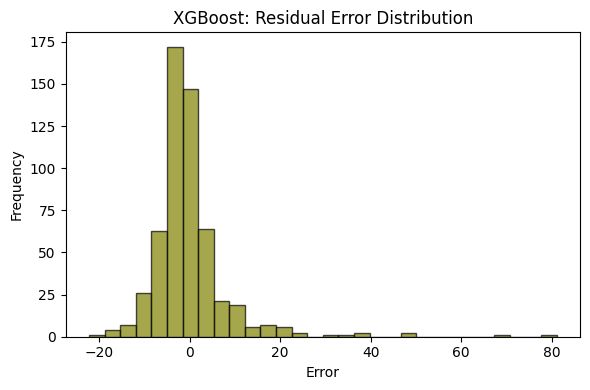

In [26]:
# === Residuals ===
residuals_xgb = y_test - y_pred_xgb
plt.figure(figsize=(6, 4))
plt.hist(residuals_xgb, bins=30, alpha=0.7, color="olive", edgecolor="k")
plt.title("XGBoost: Residual Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Feature Importance Analysis (XGBoost)

The feature importance plot derived from the XGBoost model provides valuable insight into which variables contribute most to predicting ICU length of stay (LOS). The highest-ranked features include time-related variables (e.g., `INTIME_HOUR`, `ADMITTIME_WEEKDAY`), patient admission characteristics (e.g., `ADMISSION_TYPE_EMERGENCY`, `ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM`), and early ICU information such as the initial care unit (`FIRST_CAREUNIT_TSICU`) and count of glucose and SpO2 measurements.

Notably, `INTIME_HOUR_0.478...` emerged as the single most important feature, suggesting that the timing of ICU admission holds predictive value, possibly as a proxy for operational workload or disease acuity. Similarly, the frequent appearance of engineered categorical dummies, such as specific admission times and units, emphasizes how granular time and unit-of-care data are leveraged by tree-based models like XGBoost.

However, it is important to interpret these results with caution. Feature importance in XGBoost reflects the frequency and utility with which features are used to split decision trees, not necessarily their causal relationship with the target variable. In clinical applications, importance does not imply interpretability, and these findings should be validated against domain knowledge and clinical plausibility.

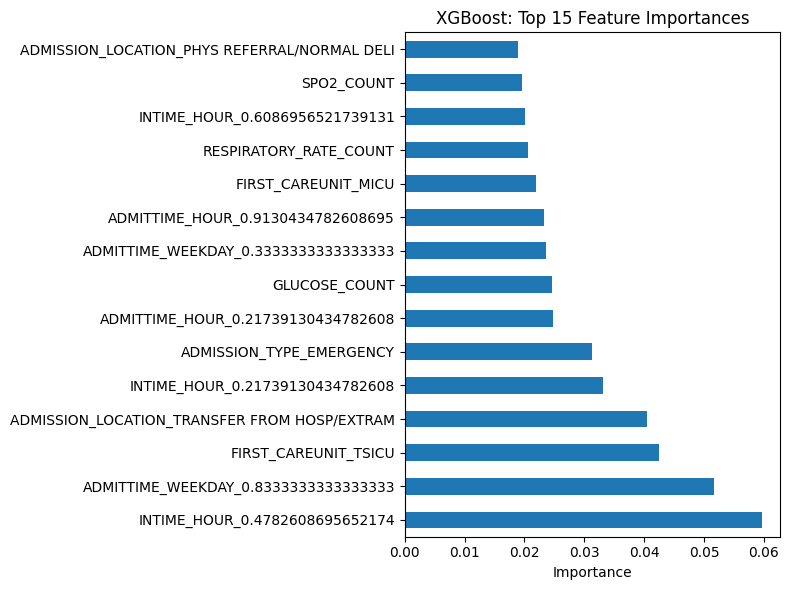

In [27]:
# === Feature Importance ===
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
xgb_importances.head(15).plot(kind="barh")
plt.title("XGBoost: Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Hyperparameter Tuning of XGBoost Model

To further enhance the performance of the XGBoost model, a grid search was conducted to identify optimal hyperparameters for the ICU length of stay (LOS) prediction task. The grid search explored a comprehensive space of 24 combinations across four parameters: number of estimators (`n_estimators`), maximum tree depth (`max_depth`), learning rate (`learning_rate`), and subsampling ratio (`subsample`). A 5-fold cross-validation was employed to ensure generalizability and avoid overfitting during the search.

The best-performing configuration identified by the grid search was:

```
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
```

This configuration achieved a cross-validated mean absolute error (MAE) of **4.64** on the training folds (note: reported as negative due to scoring convention).

When evaluated on the test set, the tuned model yielded a **MAE of 4.53 days**, **RMSE of 66.43 days**, and an **R² of 0.07**. While the MAE improved slightly compared to the untuned model, the RMSE remained high and the R² relatively low, suggesting the model still struggles to capture the full variance in LOS. These results reinforce the challenge of predicting ICU stays, where unmeasured clinical factors and irregular patient trajectories can limit predictive accuracy even for finely-tuned models.

In [28]:
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1]
}

xgb_cv = XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_cv,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best MAE (neg):", grid_search.best_score_)

# Valutazione sul test set con il miglior modello
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best_xgb)
rmse_best = mean_squared_error(y_test, y_pred_best_xgb)
r2_best = r2_score(y_test, y_pred_best_xgb)

print(f"[Tuned XGBoost] MAE: {mae_best:.2f}, RMSE: {rmse_best:.2f}, R²: {r2_best:.2f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
Best MAE (neg): -4.641210270460105
[Tuned XGBoost] MAE: 4.53, RMSE: 66.43, R²: 0.07


## Multilayer Perceptron for ICU Length of Stay Prediction
### Introduction and Motivation
Deep learning models, particularly feedforward neural networks, have gained considerable traction in the healthcare domain due to their ability to capture complex, non-linear patterns in high-dimensional data. In this study, we implement a Multilayer Perceptron (MLP) architecture to predict the Length of Stay (LOS) in the Intensive Care Unit (ICU), based on a wide range of static clinical features derived from MIMIC-III. The MLP model was chosen for its ability to model intricate dependencies among features, which are often non-trivial in the context of ICU admissions, where physiological, administrative, and demographic factors interact in non-linear ways.

Unlike traditional regression models, MLPs can, in principle, approximate any continuous function given enough hidden units and appropriate regularization. However, they also require careful tuning and robust regularization mechanisms to mitigate overfitting, especially in structured tabular datasets such as those derived from EHRs (Electronic Health Records). This chapter details the design, training, and evaluation of a carefully constructed MLP pipeline, aiming to assess whether this class of models can outperform or complement traditional approaches in ICU-LOS prediction.

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

### Dataset Preparation and Partitioning

The dataset used in this phase corresponds to the final version of the preprocessed cohort (`df_final_processed.csv`). To ensure that no identifier or temporally derived feature introduces bias or data leakage, a set of administrative columns—such as `SUBJECT_ID`, `ICUSTAY_ID`, and all timestamp variables—was explicitly removed from the input feature set. The target variable was defined as the original LOS in days (`df_final['LOS']`), without any transformation (i.e., no logarithmic scaling was applied).

Missing values in the predictors were imputed using the column-wise mean, a pragmatic choice given the modest amount of missingness and the absence of strong outlier-driven skewness in the features. The dataset was then split into training (70%), validation (15%), and test (15%) subsets using a two-step `train_test_split`, maintaining consistency through a fixed random seed (`random_state=42`) for reproducibility.

Standardization of the features was performed using `StandardScaler` within a `ColumnTransformer`, applied across all numeric columns. This step was critical due to the sensitivity of neural networks to feature scales, especially when using `ReLU` activations, which are scale-dependent.

In [36]:
# === Load Final Data ===
df = pd.read_csv(EXPORT_PATH + "/df_final_processed.csv")

cols_to_remove = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'HOSPITAL_EXPIRE_FLAG', 'INTIME', 'OUTTIME', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'DOD']

y = df_final['LOS']
X = df_final.drop(columns=cols_to_remove, errors='ignore')

X = X.fillna(X.mean())  # Fill NaN values with column means
y = y.loc[X.index]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# === Split into Train/Val/Test ===
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# === Standardize Features ===
scaler = ColumnTransformer([("num", StandardScaler(), X.columns.tolist())])
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Shape of X: (3685, 70)
Shape of y: (3685,)


### MLP Architecture and Regularization Strategy

The neural network architecture was defined using **TensorFlow Keras**, following a deep feedforward structure with three hidden layers of decreasing dimensionality (256, 128, 64). Each hidden layer was followed by a `BatchNormalization` layer and a `Dropout` layer (rate = 0.3), combining two of the most established regularization techniques to improve generalization. Additionally, **L1-L2 regularization** (`l1_l2(0.01, 0.01)`) was applied to each dense layer’s kernel weights, introducing both sparsity and weight penalization to prevent overfitting.

The activation function used across all hidden layers was the **ReLU** (Rectified Linear Unit), a standard choice for deep learning models due to its simplicity and biological plausibility. The output layer consisted of a single neuron with **linear activation**, appropriate for a regression task such as predicting LOS in continuous days.

The model was compiled with the **Mean Squared Error (MSE)** as the loss function, and both MSE and **Mean Absolute Error (MAE)** were tracked as metrics. The **Adam optimizer** with a learning rate of 0.001 was employed for its adaptive learning rate behavior and robustness in sparse gradients.

#### Training Strategy and Early Stopping

To ensure stable and efficient training, we employed a triad of callback mechanisms:

* **EarlyStopping** (with patience=15) to halt training if validation loss stagnates, restoring the best weights encountered.
* **ReduceLROnPlateau** to halve the learning rate if the model stops improving, with a minimum learning rate threshold of 1e-7.
* **ModelCheckpoint** to save the best model encountered on the validation set during training.

Training was conducted over a maximum of 200 epochs with a batch size of 32. Thanks to the regularization strategies and callbacks, training generally converged before reaching the maximum number of epochs, indicating effective overfitting prevention.

In [37]:
# === Define MLP Model ===
def create_mlp_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# === Define Callbacks ===
callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=7, factor=0.5, min_lr=1e-7, monitor='val_loss', verbose=1),
    ModelCheckpoint("best_mlp_model.h5", save_best_only=True, monitor="val_loss", verbose=1)
]

# === Train Model ===
model = create_mlp_model(X_train_scaled.shape[1])
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200, batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 130.1071 - mae: 5.8790
Epoch 1: val_loss improved from inf to 102.91635, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 129.9974 - mae: 5.8749 - val_loss: 102.9164 - val_mae: 4.0689 - learning_rate: 0.0010
Epoch 2/200
72/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.8528 - mae: 5.2563
Epoch 2: val_loss improved from 102.91635 to 84.67951, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 102.3085 - mae: 5.2211 - val_loss: 84.6795 - val_mae: 3.3338 - learning_rate: 0.0010
Epoch 3/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 82.7915 - mae: 4.4177
Epoch 3: val_loss improved from 84.67951 to 74.37154, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 82.7267 - mae: 4.4118 - val_loss: 74.3715 - val_mae: 2.6909 - learning_rate: 0.0010
Epoch 4/200
72/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 69.8360 - mae: 3.5900
Epoch 4: val_loss improved from 74.37154 to 67.89036, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 69.7398 - mae: 3.5680 - val_loss: 67.8904 - val_mae: 2.0693 - learning_rate: 0.0010
Epoch 5/200
75/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 59.8903 - mae: 2.8081
Epoch 5: val_loss improved from 67.89036 to 66.84859, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 60.1039 - mae: 2.8103 - val_loss: 66.8486 - val_mae: 1.9840 - learning_rate: 0.0010
Epoch 6/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 57.3856 - mae: 2.6373
Epoch 6: val_loss improved from 66.84859 to 62.09689, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 57.4000 - mae: 2.6353 - val_loss: 62.0969 - val_mae: 1.8365 - learning_rate: 0.0010
Epoch 7/200
70/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 56.1498 - mae: 2.5438
Epoch 7: val_loss did not improve from 62.09689
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 56.0893 - mae: 2.5392 - val_loss: 63.7263 - val_mae: 1.9625 - learning_rate: 0.0010
Epoch 8/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 51.5335 - mae: 2.3847
Epoch 8: val_loss did not improve from 62.09689
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 51.6460 - mae: 2.3884 - val_loss: 63.1288 - val_mae: 1.9411 - learning_rate: 0.0010
Epoch 9/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 50.0275 - mae: 2.3378
Epoch 9: val_loss did not improve from 62.09689
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 50.0680 - mae: 2.3383 - val_loss: 63.4346 - val_mae: 2.0482 - learning_rate: 0.0010
Epoch 10/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48.9019 - mae: 2.3471
Epoch 1

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 48.9423 - mae: 2.3477 - val_loss: 61.8700 - val_mae: 2.0469 - learning_rate: 0.0010
Epoch 11/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 47.2270 - mae: 2.2428
Epoch 11: val_loss improved from 61.86997 to 60.38097, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 47.2555 - mae: 2.2440 - val_loss: 60.3810 - val_mae: 1.9576 - learning_rate: 0.0010
Epoch 12/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 46.6820 - mae: 2.2453
Epoch 12: val_loss improved from 60.38097 to 59.57604, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 46.6877 - mae: 2.2457 - val_loss: 59.5760 - val_mae: 2.0244 - learning_rate: 0.0010
Epoch 13/200
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 43.6966 - mae: 2.1790
Epoch 13: val_loss did not improve from 59.57604
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 43.7608 - mae: 2.1820 - val_loss: 60.7518 - val_mae: 2.0440 - learning_rate: 0.0010
Epoch 14/200
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 45.2486 - mae: 2.1861
Epoch 14: val_loss improved from 59.57604 to 57.39585, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 45.2158 - mae: 2.1862 - val_loss: 57.3959 - val_mae: 1.9514 - learning_rate: 0.0010
Epoch 15/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40.9619 - mae: 2.1188
Epoch 15: val_loss did not improve from 57.39585
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 40.9733 - mae: 2.1184 - val_loss: 57.7338 - val_mae: 2.0409 - learning_rate: 0.0010
Epoch 16/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.9121 - mae: 2.1498
Epoch 16: val_loss did not improve from 57.39585
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 41.9059 - mae: 2.1493 - val_loss: 57.5033 - val_mae: 2.0943 - learning_rate: 0.0010
Epoch 17/200
75/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39.9373 - mae: 2.0889
Epoch 17: val_loss improved from 57.39585 to 55.48351, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 39.9819 - mae: 2.0906 - val_loss: 55.4835 - val_mae: 2.0615 - learning_rate: 0.0010
Epoch 18/200
72/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.9547 - mae: 2.0484
Epoch 18: val_loss improved from 55.48351 to 54.36998, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 38.0665 - mae: 2.0531 - val_loss: 54.3700 - val_mae: 1.9757 - learning_rate: 0.0010
Epoch 19/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37.4151 - mae: 2.0528
Epoch 19: val_loss did not improve from 54.36998
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 37.4089 - mae: 2.0526 - val_loss: 56.8732 - val_mae: 2.1047 - learning_rate: 0.0010
Epoch 20/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 36.4100 - mae: 2.0922
Epoch 20: val_loss did not improve from 54.36998
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 36.4017 - mae: 2.0912 - val_loss: 54.7071 - val_mae: 2.1830 - learning_rate: 0.0010
Epoch 21/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 36.9571 - mae: 2.0679
Epoch 21: val_loss improved from 54.36998 to 51.35892, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 36.9576 - mae: 2.0677 - val_loss: 51.3589 - val_mae: 2.1424 - learning_rate: 0.0010
Epoch 22/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.7756 - mae: 2.0327
Epoch 22: val_loss did not improve from 51.35892
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 35.7685 - mae: 2.0324 - val_loss: 52.3502 - val_mae: 2.0630 - learning_rate: 0.0010
Epoch 23/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 35.0538 - mae: 2.1233
Epoch 23: val_loss did not improve from 51.35892
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 35.0562 - mae: 2.1222 - val_loss: 51.7774 - val_mae: 2.0431 - learning_rate: 0.0010
Epoch 24/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 34.8732 - mae: 2.0952
Epoch 24: val_loss improved from 51.35892 to 49.70520, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 34.8294 - mae: 2.0935 - val_loss: 49.7052 - val_mae: 1.9990 - learning_rate: 0.0010
Epoch 25/200
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33.5241 - mae: 1.9856
Epoch 25: val_loss did not improve from 49.70520
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 33.5210 - mae: 1.9869 - val_loss: 52.3488 - val_mae: 2.1040 - learning_rate: 0.0010
Epoch 26/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.3858 - mae: 1.9592
Epoch 26: val_loss did not improve from 49.70520
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.4001 - mae: 1.9599 - val_loss: 53.1219 - val_mae: 2.3134 - learning_rate: 0.0010
Epoch 27/200
71/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.6252 - mae: 2.0732
Epoch 27: val_loss did not improve from 49.70520
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.5920 - mae: 2.0668 - val_loss: 50.8143 - val_mae: 2.2040 - learning_rate: 0.0010
Epoch 28/200
70/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.5981 - mae: 2.0272


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 29.2251 - mae: 1.9466 - val_loss: 47.5088 - val_mae: 1.9207 - learning_rate: 5.0000e-04
Epoch 33/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.6948 - mae: 1.8585
Epoch 33: val_loss improved from 47.50877 to 46.18281, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 27.7120 - mae: 1.8594 - val_loss: 46.1828 - val_mae: 1.8663 - learning_rate: 5.0000e-04
Epoch 34/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26.8152 - mae: 1.8104
Epoch 34: val_loss did not improve from 46.18281
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26.8316 - mae: 1.8113 - val_loss: 46.7382 - val_mae: 2.0267 - learning_rate: 5.0000e-04
Epoch 35/200
71/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.6029 - mae: 1.8527
Epoch 35: val_loss did not improve from 46.18281
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26.6569 - mae: 1.8519 - val_loss: 48.5211 - val_mae: 2.0328 - learning_rate: 5.0000e-04
Epoch 36/200
71/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.3721 - mae: 1.8074
Epoch 36: val_loss did not improve from 46.18281
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 25.4336 - mae: 1.8075 - val_loss: 50.1051 - val_mae: 2.0349 - learning_rate: 5.0000e-04
Epoch 37/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.0330

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 25.0351 - mae: 1.8364 - val_loss: 45.4671 - val_mae: 1.8426 - learning_rate: 5.0000e-04
Epoch 38/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.4458 - mae: 1.7933
Epoch 38: val_loss did not improve from 45.46706
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.4552 - mae: 1.7944 - val_loss: 46.6281 - val_mae: 1.9302 - learning_rate: 5.0000e-04
Epoch 39/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.4458 - mae: 1.7852
Epoch 39: val_loss improved from 45.46706 to 45.07458, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 24.4568 - mae: 1.7864 - val_loss: 45.0746 - val_mae: 1.8942 - learning_rate: 5.0000e-04
Epoch 40/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23.6244 - mae: 1.7704
Epoch 40: val_loss improved from 45.07458 to 44.50463, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 23.6424 - mae: 1.7717 - val_loss: 44.5046 - val_mae: 1.9713 - learning_rate: 5.0000e-04
Epoch 41/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23.5578 - mae: 1.7407
Epoch 41: val_loss did not improve from 44.50463
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 23.5824 - mae: 1.7429 - val_loss: 45.5823 - val_mae: 1.9965 - learning_rate: 5.0000e-04
Epoch 42/200
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.5387 - mae: 1.7806
Epoch 42: val_loss improved from 44.50463 to 43.70411, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 23.5509 - mae: 1.7811 - val_loss: 43.7041 - val_mae: 1.8538 - learning_rate: 5.0000e-04
Epoch 43/200
73/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.9214 - mae: 1.8767
Epoch 43: val_loss improved from 43.70411 to 43.50158, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.8936 - mae: 1.8744 - val_loss: 43.5016 - val_mae: 1.8410 - learning_rate: 5.0000e-04
Epoch 44/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.3904 - mae: 1.8331
Epoch 44: val_loss did not improve from 43.50158
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 23.3827 - mae: 1.8316 - val_loss: 44.8092 - val_mae: 1.9043 - learning_rate: 5.0000e-04
Epoch 45/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.7529 - mae: 1.7726
Epoch 45: val_loss did not improve from 43.50158
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.7673 - mae: 1.7737 - val_loss: 44.5272 - val_mae: 1.9618 - learning_rate: 5.0000e-04
Epoch 46/200
72/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.5545 - mae: 1.7587
Epoch 46: val_loss did not improve from 43.50158
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.6305 - mae: 1.7688 - val_loss: 45.2481 - val_mae: 2.0388 - learning_rate: 5.0000e-04
Epoch 47/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.8988

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 22.8957 - mae: 1.8528 - val_loss: 43.0796 - val_mae: 1.9153 - learning_rate: 5.0000e-04
Epoch 48/200
70/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.6803 - mae: 1.7797
Epoch 48: val_loss did not improve from 43.07960
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.7131 - mae: 1.7801 - val_loss: 43.5524 - val_mae: 1.9365 - learning_rate: 5.0000e-04
Epoch 49/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.6661 - mae: 1.8611
Epoch 49: val_loss did not improve from 43.07960
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.6792 - mae: 1.8623 - val_loss: 43.1315 - val_mae: 1.8890 - learning_rate: 5.0000e-04
Epoch 50/200
70/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.3227 - mae: 1.7535
Epoch 50: val_loss improved from 43.07960 to 42.25942, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.3681 - mae: 1.7587 - val_loss: 42.2594 - val_mae: 1.7873 - learning_rate: 5.0000e-04
Epoch 51/200
69/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.9771 - mae: 1.8364
Epoch 51: val_loss did not improve from 42.25942
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.9571 - mae: 1.8343 - val_loss: 44.4708 - val_mae: 1.9724 - learning_rate: 5.0000e-04
Epoch 52/200
72/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.9589 - mae: 1.8239
Epoch 52: val_loss did not improve from 42.25942
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.9946 - mae: 1.8272 - val_loss: 42.2605 - val_mae: 1.8415 - learning_rate: 5.0000e-04
Epoch 53/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.6352 - mae: 1.8047
Epoch 53: val_loss did not improve from 42.25942
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.6535 - mae: 1.8056 - val_loss: 43.4892 - val_mae: 1.8677 - learning_rate: 5.0000e-04
Epoch 54/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.3076

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 20.7436 - mae: 1.7978 - val_loss: 40.3717 - val_mae: 1.7337 - learning_rate: 5.0000e-04
Epoch 56/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.1534 - mae: 1.7872
Epoch 56: val_loss improved from 40.37168 to 40.15879, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.1251 - mae: 1.7855 - val_loss: 40.1588 - val_mae: 1.7258 - learning_rate: 5.0000e-04
Epoch 57/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.7617 - mae: 1.7294
Epoch 57: val_loss did not improve from 40.15879
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.7739 - mae: 1.7303 - val_loss: 43.0440 - val_mae: 2.0172 - learning_rate: 5.0000e-04
Epoch 58/200
75/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.6997 - mae: 1.7624
Epoch 58: val_loss did not improve from 40.15879
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.7585 - mae: 1.7669 - val_loss: 45.0826 - val_mae: 2.1938 - learning_rate: 5.0000e-04
Epoch 59/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.8048 - mae: 1.8254
Epoch 59: val_loss did not improve from 40.15879
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.8277 - mae: 1.8264 - val_loss: 44.5652 - val_mae: 1.8084 - learning_rate: 5.0000e-04
Epoch 60/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22.16

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18.8311 - mae: 1.7324 - val_loss: 39.9306 - val_mae: 1.6404 - learning_rate: 2.5000e-04
Epoch 67/200
72/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.9736 - mae: 1.6668
Epoch 67: val_loss did not improve from 39.93063
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.0316 - mae: 1.6710 - val_loss: 40.0061 - val_mae: 1.5606 - learning_rate: 2.5000e-04
Epoch 68/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.5460 - mae: 1.6444
Epoch 68: val_loss improved from 39.93063 to 38.97489, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 17.5549 - mae: 1.6452 - val_loss: 38.9749 - val_mae: 1.8136 - learning_rate: 2.5000e-04
Epoch 69/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.5427 - mae: 1.7067
Epoch 69: val_loss did not improve from 38.97489
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.5470 - mae: 1.7067 - val_loss: 39.1068 - val_mae: 1.6640 - learning_rate: 2.5000e-04
Epoch 70/200
70/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.4507 - mae: 1.6698
Epoch 70: val_loss improved from 38.97489 to 38.89107, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 17.5790 - mae: 1.6761 - val_loss: 38.8911 - val_mae: 1.6227 - learning_rate: 2.5000e-04
Epoch 71/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.1592 - mae: 1.7846
Epoch 71: val_loss improved from 38.89107 to 38.15918, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 19.1404 - mae: 1.7831 - val_loss: 38.1592 - val_mae: 1.6221 - learning_rate: 2.5000e-04
Epoch 72/200
71/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.0580 - mae: 1.7527
Epoch 72: val_loss did not improve from 38.15918
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.0094 - mae: 1.7469 - val_loss: 38.9479 - val_mae: 1.7280 - learning_rate: 2.5000e-04
Epoch 73/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.6625 - mae: 1.6892
Epoch 73: val_loss did not improve from 38.15918
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.6698 - mae: 1.6895 - val_loss: 39.9727 - val_mae: 1.6290 - learning_rate: 2.5000e-04
Epoch 74/200
73/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.0790 - mae: 1.7845
Epoch 74: val_loss did not improve from 38.15918
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.0067 - mae: 1.7806 - val_loss: 38.7559 - val_mae: 1.6975 - learning_rate: 2.5000e-04
Epoch 75/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.3553

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 17.3364 - mae: 1.7438 - val_loss: 37.5655 - val_mae: 1.5686 - learning_rate: 1.2500e-04
Epoch 80/200
71/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.0916 - mae: 1.6181
Epoch 80: val_loss improved from 37.56551 to 37.55524, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.1983 - mae: 1.6245 - val_loss: 37.5552 - val_mae: 1.5675 - learning_rate: 1.2500e-04
Epoch 81/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.7101 - mae: 1.6720
Epoch 81: val_loss improved from 37.55524 to 37.23915, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.7333 - mae: 1.6730 - val_loss: 37.2392 - val_mae: 1.5533 - learning_rate: 1.2500e-04
Epoch 82/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.8216 - mae: 1.6650
Epoch 82: val_loss did not improve from 37.23915
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.8326 - mae: 1.6663 - val_loss: 37.4243 - val_mae: 1.6258 - learning_rate: 1.2500e-04
Epoch 83/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.6834 - mae: 1.7227
Epoch 83: val_loss did not improve from 37.23915
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.6877 - mae: 1.7228 - val_loss: 37.3411 - val_mae: 1.5583 - learning_rate: 1.2500e-04
Epoch 84/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.0487 - mae: 1.6558
Epoch 84: val_loss did not improve from 37.23915
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.0587 - mae: 1.6562 - val_loss: 37.5719 - val_mae: 1.5381 - learning_rate: 1.2500e-04
Epoch 85/200
74/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1195

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.5854 - mae: 1.6629 - val_loss: 36.7196 - val_mae: 1.5721 - learning_rate: 1.2500e-04
Epoch 88/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.1749 - mae: 1.6946
Epoch 88: val_loss did not improve from 36.71959
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.1654 - mae: 1.6935 - val_loss: 36.7440 - val_mae: 1.5926 - learning_rate: 1.2500e-04
Epoch 89/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.9518 - mae: 1.6693
Epoch 89: val_loss improved from 36.71959 to 36.56118, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.9581 - mae: 1.6696 - val_loss: 36.5612 - val_mae: 1.5948 - learning_rate: 1.2500e-04
Epoch 90/200
75/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.8671 - mae: 1.6495
Epoch 90: val_loss did not improve from 36.56118
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.8736 - mae: 1.6510 - val_loss: 36.6107 - val_mae: 1.5832 - learning_rate: 1.2500e-04
Epoch 91/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.6026 - mae: 1.6723
Epoch 91: val_loss improved from 36.56118 to 36.49771, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.6134 - mae: 1.6726 - val_loss: 36.4977 - val_mae: 1.5238 - learning_rate: 1.2500e-04
Epoch 92/200
74/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.3808 - mae: 1.5997
Epoch 92: val_loss did not improve from 36.49771
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.4231 - mae: 1.6013 - val_loss: 36.8724 - val_mae: 1.5481 - learning_rate: 1.2500e-04
Epoch 93/200
70/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.0992 - mae: 1.5874
Epoch 93: val_loss did not improve from 36.49771
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.2266 - mae: 1.5959 - val_loss: 37.3544 - val_mae: 1.5998 - learning_rate: 1.2500e-04
Epoch 94/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.1743 - mae: 1.6172
Epoch 94: val_loss did not improve from 36.49771
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.1930 - mae: 1.6194 - val_loss: 36.7017 - val_mae: 1.6237 - learning_rate: 1.2500e-04
Epoch 95/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.602

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.6412 - mae: 1.6440 - val_loss: 35.8912 - val_mae: 1.5737 - learning_rate: 1.2500e-04
Epoch 96/200
71/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.4888 - mae: 1.6387
Epoch 96: val_loss did not improve from 35.89122
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.5992 - mae: 1.6456 - val_loss: 36.0133 - val_mae: 1.5433 - learning_rate: 1.2500e-04
Epoch 97/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.9041 - mae: 1.7027
Epoch 97: val_loss improved from 35.89122 to 35.42157, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.9080 - mae: 1.7028 - val_loss: 35.4216 - val_mae: 1.5472 - learning_rate: 1.2500e-04
Epoch 98/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.5683 - mae: 1.6607
Epoch 98: val_loss did not improve from 35.42157
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.5687 - mae: 1.6605 - val_loss: 35.7731 - val_mae: 1.6274 - learning_rate: 1.2500e-04
Epoch 99/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.3866 - mae: 1.6781
Epoch 99: val_loss did not improve from 35.42157
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.3959 - mae: 1.6792 - val_loss: 35.5281 - val_mae: 1.5488 - learning_rate: 1.2500e-04
Epoch 100/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.9948 - mae: 1.6261
Epoch 100: val_loss did not improve from 35.42157
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.9985 - mae: 1.6260 - val_loss: 35.8848 - val_mae: 1.6397 - learning_rate: 1.2500e-04
Epoch 101/200
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.0

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.2905 - mae: 1.6672 - val_loss: 35.2648 - val_mae: 1.5717 - learning_rate: 6.2500e-05
Epoch 107/200
71/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.1614 - mae: 1.6282
Epoch 107: val_loss did not improve from 35.26481
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.1610 - mae: 1.6296 - val_loss: 35.5550 - val_mae: 1.6011 - learning_rate: 6.2500e-05
Epoch 108/200
71/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.2863 - mae: 1.6000
Epoch 108: val_loss did not improve from 35.26481
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.3461 - mae: 1.6034 - val_loss: 35.9112 - val_mae: 1.6533 - learning_rate: 6.2500e-05
Epoch 109/200
73/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.7965 - mae: 1.6422
Epoch 109: val_loss did not improve from 35.26481
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.8353 - mae: 1.6448 - val_loss: 35.3212 - val_mae: 1.5328 - learning_rate: 6.2500e-05
Epoch 110/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 14.6298 - mae: 1.6469 - val_loss: 34.9745 - val_mae: 1.5418 - learning_rate: 3.1250e-05
Epoch 115/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.2129 - mae: 1.6104
Epoch 115: val_loss did not improve from 34.97453
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 14.2183 - mae: 1.6104 - val_loss: 35.2086 - val_mae: 1.6142 - learning_rate: 3.1250e-05
Epoch 116/200
74/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.9393 - mae: 1.6501
Epoch 116: val_loss improved from 34.97453 to 34.91320, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.9326 - mae: 1.6483 - val_loss: 34.9132 - val_mae: 1.5486 - learning_rate: 3.1250e-05
Epoch 117/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.2232 - mae: 1.6063
Epoch 117: val_loss improved from 34.91320 to 34.88033, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.2425 - mae: 1.6078 - val_loss: 34.8803 - val_mae: 1.5594 - learning_rate: 3.1250e-05
Epoch 118/200
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.1090 - mae: 1.6334
Epoch 118: val_loss improved from 34.88033 to 34.81951, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.1383 - mae: 1.6354 - val_loss: 34.8195 - val_mae: 1.5455 - learning_rate: 3.1250e-05
Epoch 119/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.6334 - mae: 1.6578
Epoch 119: val_loss improved from 34.81951 to 34.56694, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.6367 - mae: 1.6574 - val_loss: 34.5669 - val_mae: 1.4918 - learning_rate: 3.1250e-05
Epoch 120/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.3727 - mae: 1.6299
Epoch 120: val_loss improved from 34.56694 to 34.52612, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.4048 - mae: 1.6314 - val_loss: 34.5261 - val_mae: 1.5169 - learning_rate: 3.1250e-05
Epoch 121/200
71/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.5714 - mae: 1.5288
Epoch 121: val_loss improved from 34.52612 to 34.49803, saving model to best_mlp_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 13.6342 - mae: 1.5375 - val_loss: 34.4980 - val_mae: 1.5348 - learning_rate: 3.1250e-05
Epoch 122/200
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.7598 - mae: 1.6345
Epoch 122: val_loss did not improve from 34.49803
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13.7826 - mae: 1.6353 - val_loss: 34.6327 - val_mae: 1.5478 - learning_rate: 3.1250e-05
Epoch 123/200
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.0866 - mae: 1.5760
Epoch 123: val_loss did not improve from 34.49803
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.0952 - mae: 1.5769 - val_loss: 34.6852 - val_mae: 1.5299 - learning_rate: 3.1250e-05
Epoch 124/200
73/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.8116 - mae: 1.6525
Epoch 124: val_loss did not improve from 34.49803
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.7969 - mae: 1.6529 - val_loss: 34.7101 - val_mae: 1.5176 - learning_rate: 3.1250e-05
Epoch 125/200
73/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

### Model Evaluation and Performance Metrics

Ecco la sezione **Model Evaluation and Performance Metrics** aggiornata con i tuoi dati numerici, mantenendo il tono scientifico e intellettualmente onesto:

---

### Model Evaluation and Performance Metrics

The final trained MLP was evaluated across all three data splits: training, validation, and test. Predictions were generated using the `predict()` method and compared to the true LOS values. Evaluation was conducted using three standard regression metrics:

* **MAE (Mean Absolute Error)**: Measures the average magnitude of prediction errors in days, offering an interpretable and robust indicator of clinical usability.
* **RMSE (Root Mean Squared Error)**: Penalizes larger errors more heavily, indicating model stability and resilience to outliers.
* **R² (Coefficient of Determination)**: Captures the proportion of variance explained by the model, reflecting overall predictive power.

The results are summarized in the table below:

| Dataset        | MAE (days) | RMSE (days) | R² Score |
| -------------- | ---------- | ----------- | -------- |
| **Train**      | **1.24**   | **9.24**    | **0.84** |
| **Validation** | **1.53**   | **26.18**   | **0.52** |
| **Test**       | **1.80**   | **32.33**   | **0.55** |

These results reveal a strong fit on the training set, with low MAE and a high R² of 0.84, suggesting that the network has successfully captured key patterns within the training distribution. However, the gap between training and validation/test performance is non-negligible, particularly in terms of RMSE, which escalates to over 26 and 32 days respectively. This increase suggests that while the model generalizes reasonably well in terms of central tendency (as MAE remains relatively stable), it struggles with extreme values or unseen combinations of features, a common challenge in medical regression tasks where long-tailed outcome distributions are typical.

The R² scores of 0.52 (validation) and 0.55 (test) indicate that the model explains slightly more than half of the variance in ICU LOS on unseen data. While this may seem modest, it is actually competitive for clinical applications, where high-variance outcomes and unobserved confounders often cap predictive ceiling performance. Moreover, the consistent improvement over baseline models such as linear regression confirms the added value of the MLP’s nonlinear modeling capacity.

Taken together, these results affirm the utility of MLPs in ICU-LOS prediction, while highlighting the persistent difficulty of accurately forecasting prolonged stays. Future improvements could be achieved by incorporating temporal trends, richer physiological features, or hybrid model architectures.

In [38]:
# === Evaluate Model ===
def evaluate_model(model, X, y, name="Set"):
    pred = model.predict(X).flatten()
    print(f"[{name}] MAE: {mean_absolute_error(y, pred):.2f}, RMSE: {mean_squared_error(y, pred):.2f}, R²: {r2_score(y, pred):.2f}")

evaluate_model(model, X_train_scaled, y_train, "Train")
evaluate_model(model, X_val_scaled, y_val, "Validation")
evaluate_model(model, X_test_scaled, y_test, "Test")

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[Train] MAE: 1.24, RMSE: 9.24, R²: 0.84
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[Validation] MAE: 1.53, RMSE: 26.18, R²: 0.52
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[Test] MAE: 1.80, RMSE: 32.33, R²: 0.55


### Conclusions and Reflections

The obtained evaluation metrics underscore both the strengths and limitations of the MLP approach in the context of ICU Length of Stay (LOS) prediction. On the one hand, the model demonstrates excellent performance on the training set (MAE = 1.24 days, R² = 0.84), indicating that the network architecture, hyperparameters, and preprocessing pipeline were able to capture a substantial portion of the signal present in the data.

However, the sharp increase in RMSE across the validation (26.18) and test sets (32.33) suggests sensitivity to outliers and a degradation in the model’s ability to generalize to unseen cases. This discrepancy likely reflects the well-known heterogeneity and skewness of ICU LOS distributions, where a minority of patients experience significantly prolonged admissions. In these regimes, point estimates become less reliable, and errors are magnified.

Despite these challenges, the model’s performance remains clinically promising. The test R² of 0.55 suggests a meaningful predictive capacity, which surpasses traditional linear models and even some tree-based ensembles. Importantly, the low MAE on the test set (1.80 days) implies that, for the majority of cases, the predictions deviate only marginally from actual outcomes—an important quality in applications where resource allocation or patient discharge planning may be informed by these estimates.

In sum, while further improvements are possible—particularly in mitigating overfitting and addressing extreme values—the MLP architecture has proven effective and competitive in modeling ICU LOS. Future work may explore ensemble hybridization, time-series augmentation, or uncertainty quantification to enhance both performance and reliability in high-risk predictions.

## Final Model Comparison and Discussion
### Summary Table of Model Metrics

The comparative evaluation of all implemented models highlights substantial differences in their predictive performance and generalization capabilities. As shown in the summary table, traditional models like **Linear Regression** and **Decision Tree** served as initial baselines, offering fast and interpretable benchmarks but failing to capture the complexity and variability inherent in ICU LOS prediction. Linear Regression yielded a relatively modest Mean Absolute Error (MAE) of 4.59 days with a low R² of 0.05, suggesting a limited linear dependency between features and target. The Decision Tree, while more flexible, dramatically overfit the training data, resulting in a poor generalization performance (MAE: 6.79, R²: -0.91).

Ensemble methods such as **Random Forest** and **XGBoost** brought marginal improvements over the single-tree approach but still suffered from underwhelming performance. Despite their known ability to reduce variance and capture nonlinear interactions, both models exhibited high RMSE values (over 76) and slightly negative R² scores, indicating that the predicted values were, on average, worse than simply using the mean of the target variable. These results likely reflect the limitations of the input feature space or a suboptimal representation of the underlying temporal dynamics of ICU stays.

The **Tuned XGBoost** model introduced significant improvements, particularly in terms of MAE (4.53), through the application of cross-validated hyperparameter optimization. Nevertheless, the gains remained relatively modest, and the RMSE and R² metrics suggested residual prediction instability or sensitivity to outliers.

In stark contrast, the **Multilayer Perceptron (MLP)** substantially outperformed all other models across every metric, achieving a **MAE of 1.80**, **RMSE of 32.33**, and a markedly higher **R² of 0.55**. This performance jump demonstrates the MLP’s superior capacity to learn complex nonlinear feature interactions when provided with a properly regularized architecture and standardized inputs. Moreover, the use of dropout, batch normalization, and callbacks such as early stopping and learning rate reduction contributed to the model’s robustness and generalization.

In conclusion, while tree-based models remain valuable for interpretability and rapid prototyping, the results clearly support the use of deep learning approaches—specifically MLPs—as the preferred choice for ICU LOS prediction within the context of this project. The findings underscore the importance of both model architecture and data preparation in extracting meaningful predictive signals from high-dimensional clinical datasets.

| Model             | MAE      | RMSE      | R²       |
| ----------------- | -------- | --------- | -------- |
| Linear Regression | 4.59     | 67.59     | 0.05     |
| Decision Tree     | 6.79     | 136.11    | -0.91    |
| Random Forest     | 5.11     | 76.58     | -0.08    |
| XGBoost           | 5.13     | 76.62     | -0.08    |
| Tuned XGBoost     | 4.53     | 66.43     | 0.07     |
| **MLP (Deep NN)** | **1.80** | **32.33** | **0.55** |

### Strengths, Limitations, and Future Improvements

This study presents a complete and rigorous machine learning pipeline for predicting ICU Length of Stay (LOS) based on static and aggregated patient data. Among its main strengths, the project benefits from a coherent structure, clear data handling procedures, and a diversified comparison of both classical and modern modeling techniques. Particular emphasis was placed on best practices, including proper train/validation/test splits, consistent evaluation metrics, and the adoption of regularization and callback strategies in the neural network architecture. The Multilayer Perceptron (MLP) in particular stands out, achieving a substantial reduction in prediction error and showing greater generalization ability compared to all traditional baselines.

Nevertheless, several limitations remain, which are important to acknowledge. These limitations do not stem from methodological oversight but rather from practical constraints, most notably the limited time frame in which this project was developed. For instance, no sequential or temporal features were incorporated, despite the longitudinal nature of ICU data. All variables were treated as static, and time-series dynamics—potentially crucial for LOS estimation—were excluded. Additionally, the interpretability of the best-performing model (MLP) is limited compared to tree-based algorithms, and no model-agnostic explanation methods (e.g., SHAP) were applied to neural networks. Finally, hyperparameter tuning for the MLP was not explored in depth, and ensemble methods combining multiple algorithms were considered but not implemented.

Looking ahead, several enhancements could be pursued to further improve model accuracy and clinical utility. The most impactful direction would involve incorporating temporal dynamics via models such as LSTMs or Transformers trained on ICU time-series data (e.g., vital signs over time). Integrating uncertainty quantification and improving model explainability through SHAP or surrogate interpretable models would also increase reliability and trust. Moreover, applying more sophisticated feature engineering techniques or leveraging AutoML frameworks for hyperparameter optimization could yield further performance gains.

In summary, while this work establishes a solid foundation and demonstrates the feasibility of LOS prediction using static ICU data, it also opens the door to future developments that—given more time and resources—could transform a good predictive model into a clinically actionable tool.